# GJ 3470b Simulation Demo

In [1]:
%matplotlib inline

In [2]:
import pandorasat as ps
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, Distance
from pandorasat.utils import get_sky_catalog
from tqdm import tqdm

# Targets

In the simulator we have a special class for getting "targets". This will go and find the target based on a name.

In [3]:
targ = ps.Target.from_gaia("GJ 3470")

In [4]:
targ

GJ 3470 [119.77308177153017 deg, 15.391084702708277 deg]

You have access to the key parameters of the target based on either a Gaia query or a TIC query

In [5]:
targ.teff

<Quantity 3775.5 K>

You can also take a look at the spectrum, including any nearby photometry values

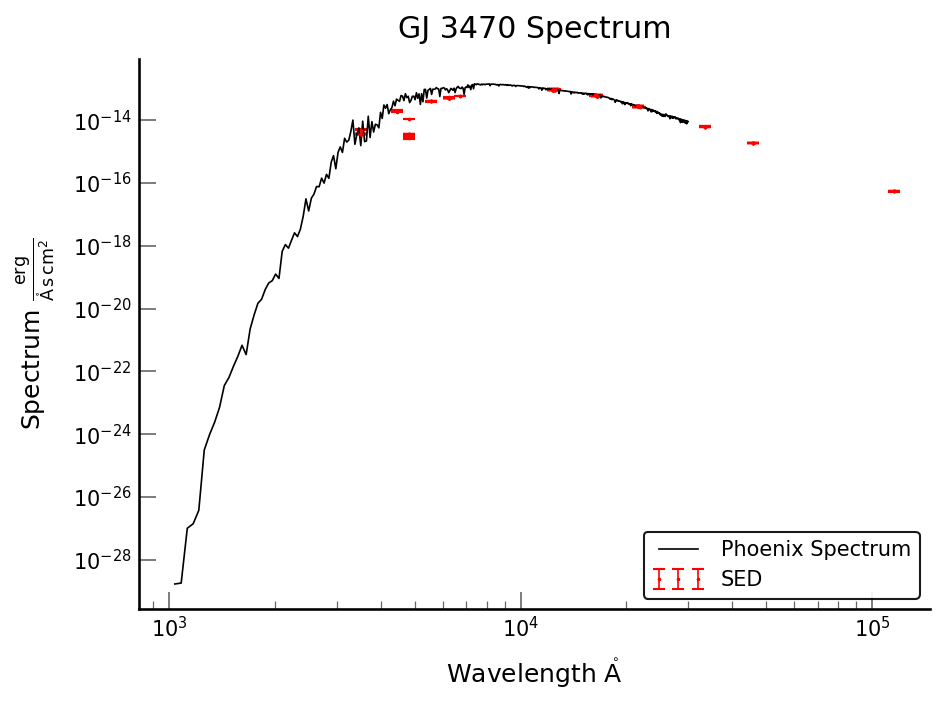

In [6]:
targ.plot_spectrum();

You can interpolate the spectrum

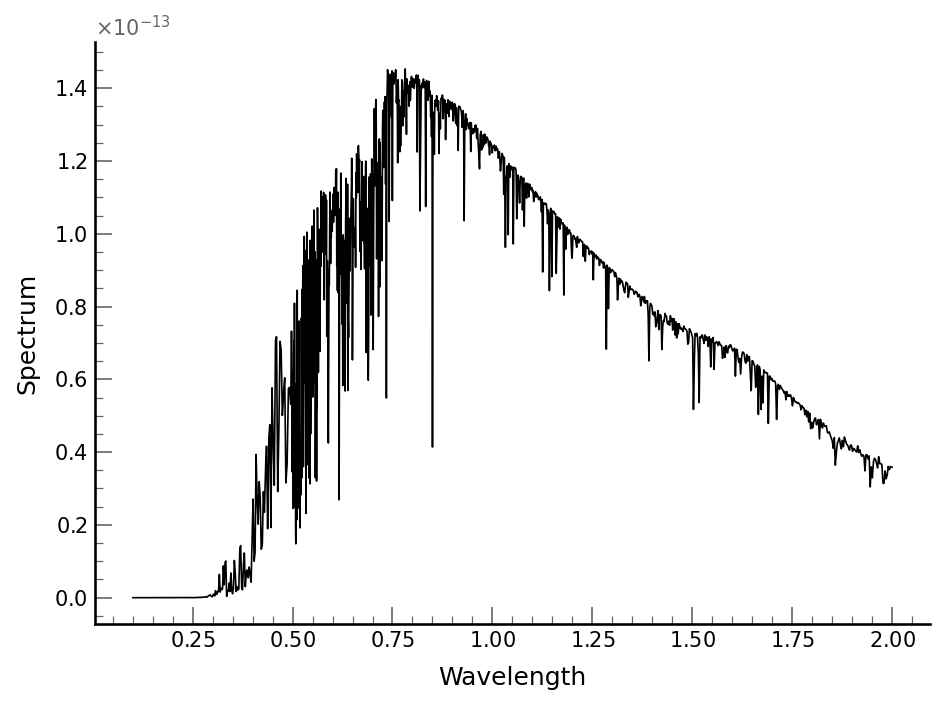

In [8]:
w = np.arange(0.1, 2, 0.0001) * u.micron
with plt.style.context(ps.PANDORASTYLE):
    fig, ax = plt.subplots()
    ax.plot(w, targ.spectrum(w))
    ax.set(xlabel='Wavelength', ylabel='Spectrum')

Finally you can use targets to get access to the planet parameters

In [9]:
targ.planets

{'b': {'pl_orbper': <Quantity 3.3366496 d>,
  'pl_tranmid': <Quantity 2455983.70421 d>,
  'pl_trandur': <Quantity 1.8984 h>,
  'pl_trandep': <Quantity 0.653 %>}}

Right now this is a fairly simple class to help us carry around the key information about a target, and this will be expanded to enable simpel models of planet transits. For now, you have access to a basic box transit.

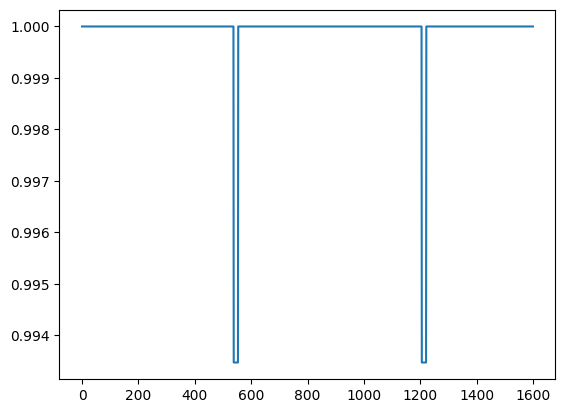

In [10]:
transit = targ.box_transit(time=np.arange(0, 8, 0.005))
plt.plot(transit)

# Pandora Observatory

The way the simulator works is that there is an `PandoraSat` class which is the Observatory. The idea is that you point the observatory, set up some observation parameters, and then you can get your simulation.

**This API could change. Things might get added or removed.**
`pandora-sat` is under construction so I'm constantly moving stuff around and changing the API to suit our needs better. If you are using `pandora-sat` and I suddenly change something and it breaks your code downstream, email me.


To start out we're going to pick a duration and a start time.

In [11]:
duration = 360*u.minute
obstime = Time(targ.planets['b']['pl_tranmid'].value - (duration/2).to(u.day).value, format='jd')

Note these are astropy quantities and times.

I know we don't all love astropy quantities, and in fact we have good reason to be wary. 

They buy us one important thing which is a good sanity check on reasonable units, astropy will literally break if we do maths that is unphysical. 

We need an RA, Dec and angle to point at.

The RA and Dec we can get from the target above. The angle we're going to make up for now, as the optimum angle depends on our exact orbit (we need to keep solar panels pointed towards the sun).

In [12]:
p = ps.PandoraSat(targ.ra, targ.dec, 10*u.deg, duration=duration, obstime=obstime)

What is this doing?

* Setting up two subclasses to the observatory which are the NIRDA and VISDA
* Finding a catalog on sky at the correct location
* Applying a WCS with reasonable distortions to the catalog for each instrument


What is this NOT doing:

* Checking that your observation is possible (currently we have no information on the orbit of Pandora, so we can't tell if the observatory is behind the Earth). **We are not checking if there are timing constraints on this observation, or e.g. sun angle constraints.** For that you'll have to go to `pandora-scheduler` for now.

In [13]:
p

Pandora Observatory (RA: 119.773 deg, Dec: 15.391 deg, theta: 10.0 deg)

In [14]:
p.NIRDA

Pandora NIR Detector

In [15]:
p.VISDA

Pandora Visible Detector

Each of these you can "diagnose" to take a look at the PSF on that channel.

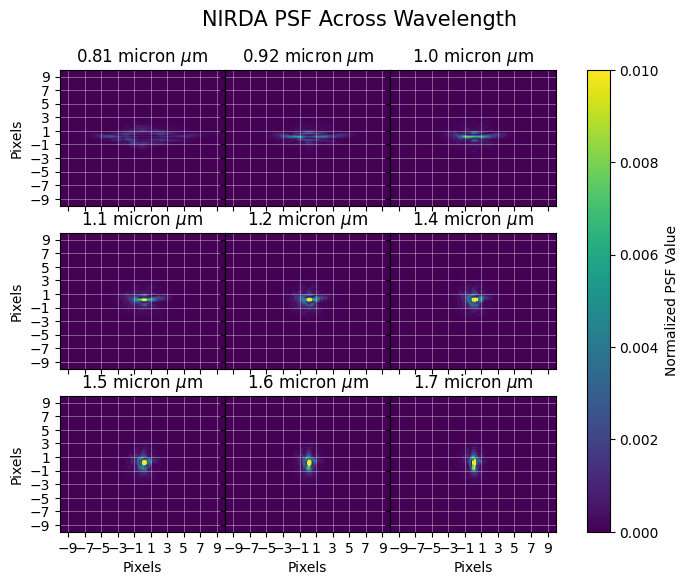

In [16]:
p.NIRDA.diagnose(n=3);

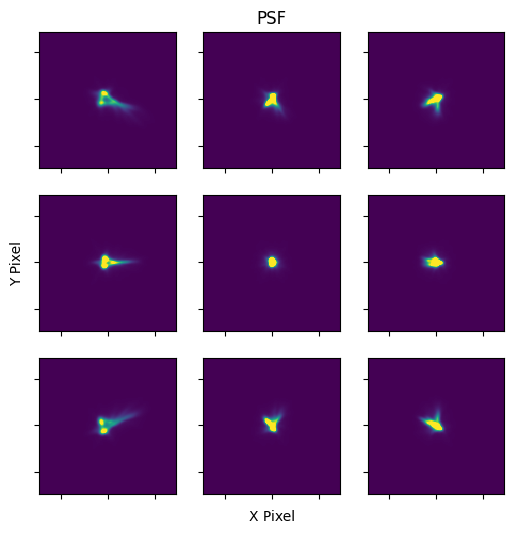

In [17]:
p.VISDA.diagnose(n=3);

You can also get our best estimate of the sensitivity

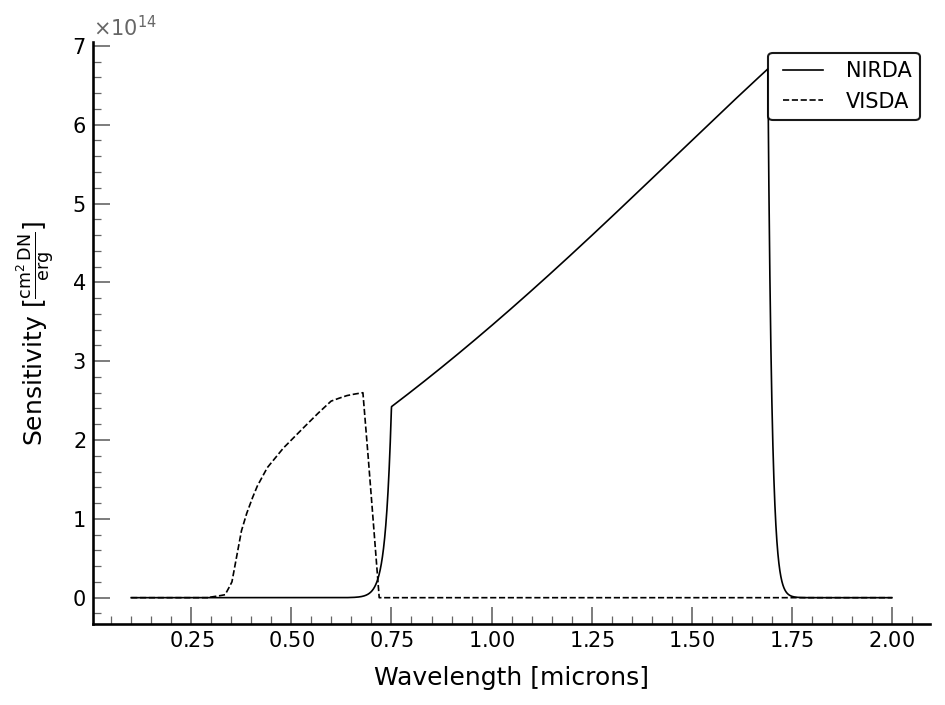

In [18]:
with plt.style.context(ps.PANDORASTYLE):
    fig, ax = plt.subplots()
    ax.plot(w, p.NIRDA.sensitivity(w), label='NIRDA', c='k', ls='-')
    ax.plot(w, p.VISDA.sensitivity(w), label='VISDA', c='k', ls='--')
    ax.set(xlabel='Wavelength [microns]', ylabel=f"Sensitivity [{p.NIRDA.sensitivity(w).unit.to_string('latex')}]")
    plt.legend()

You can look at an overview of the "footprint" of each detector on the sky.

**Note: These do not yet have the correct offsets and may not have the correct orient to each other, these are placeholders**

<AxesSubplot: title={'center': 'RA:119.773 deg Dec:15.391 deg, theta:10.0 deg'}, xlabel='RA', ylabel='Dec'>

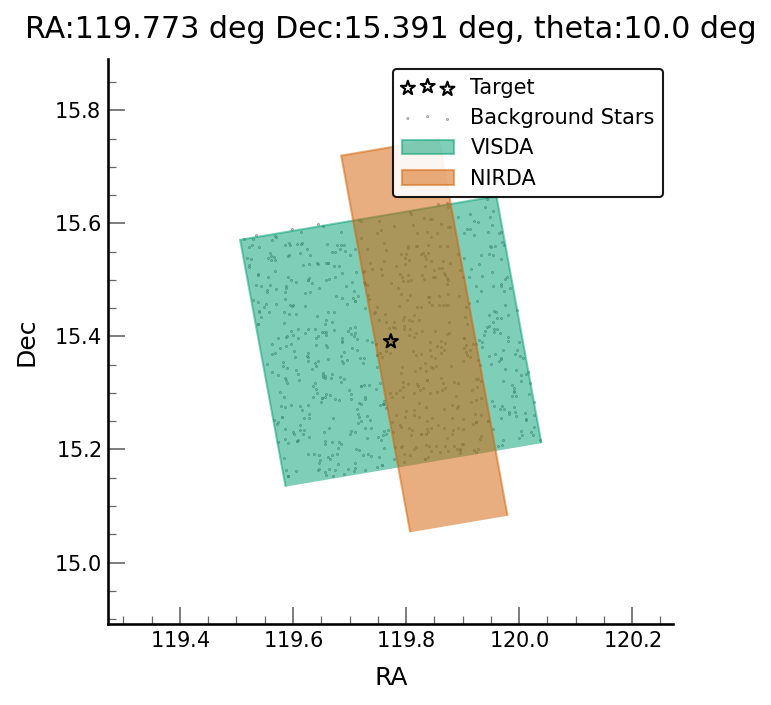

In [19]:
p.plot_footprint()

You can also plot an estimate of the "full frame image" on the visible side

**Note: The API is going through some changes, this may end up being moved to**
```python
p.VISDA.plot_FFI()
```

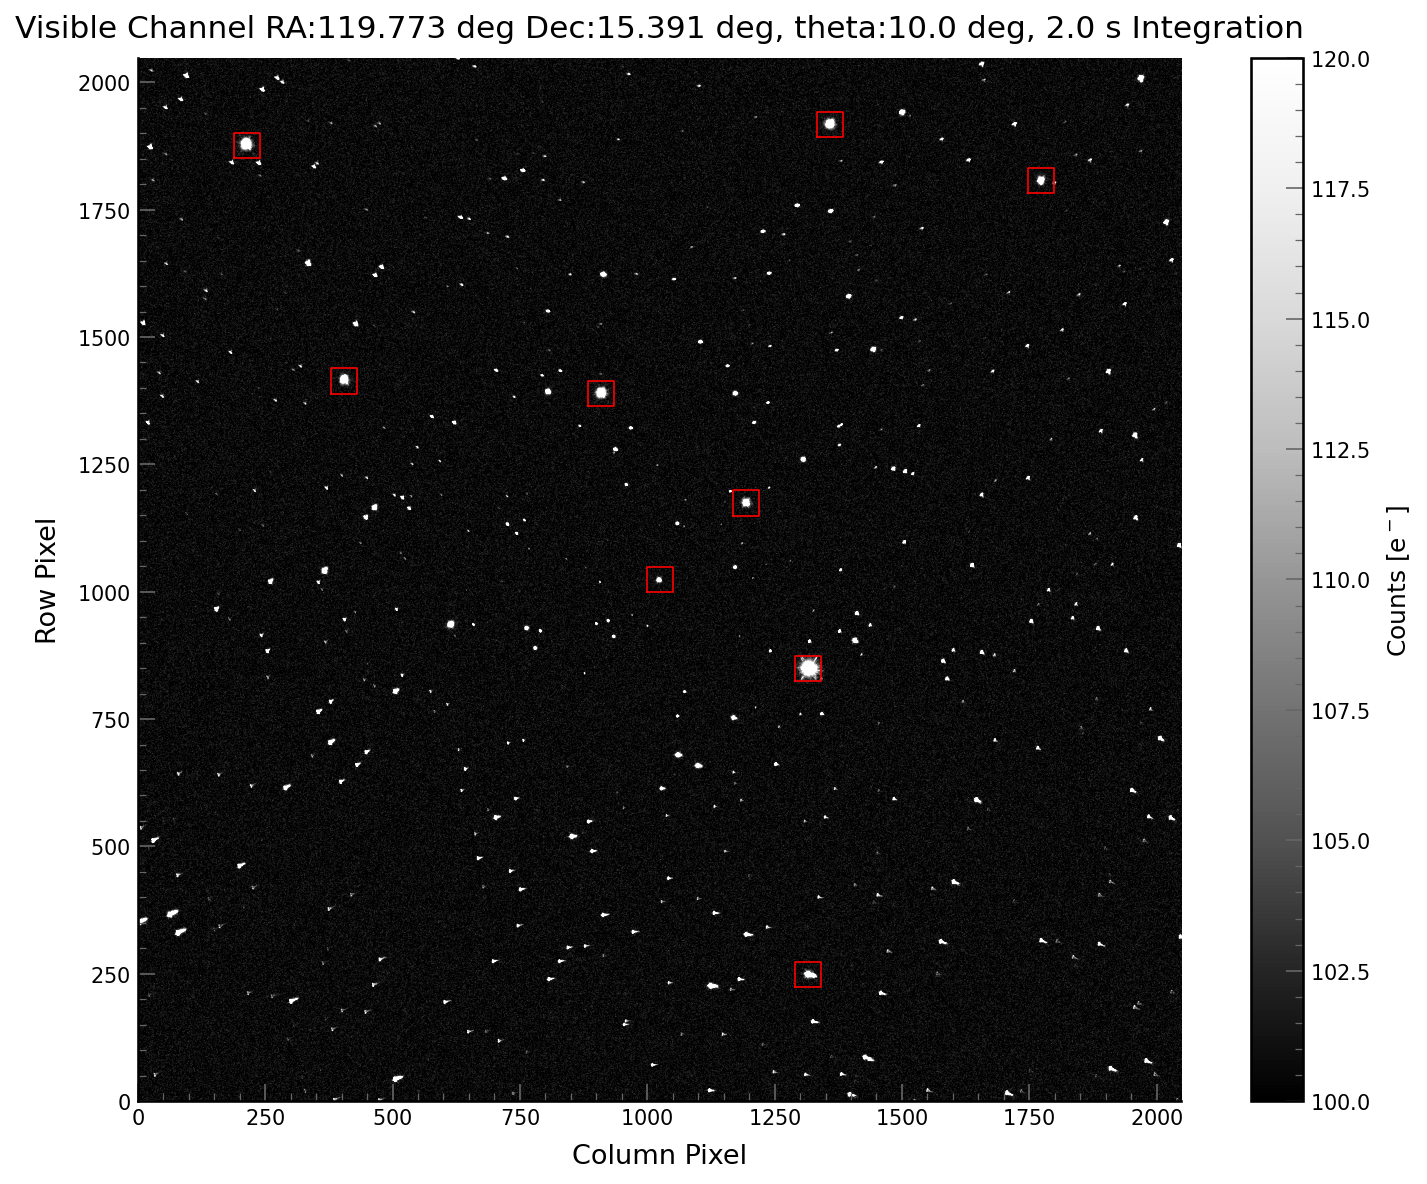

In [20]:
p.plot_FFI();

Above this has highlighted suggested stars that would be downlinked as the "background" target data. For now, this is the brightest 7 targets.

You can plot those to get an idea of the expected noise and shape.

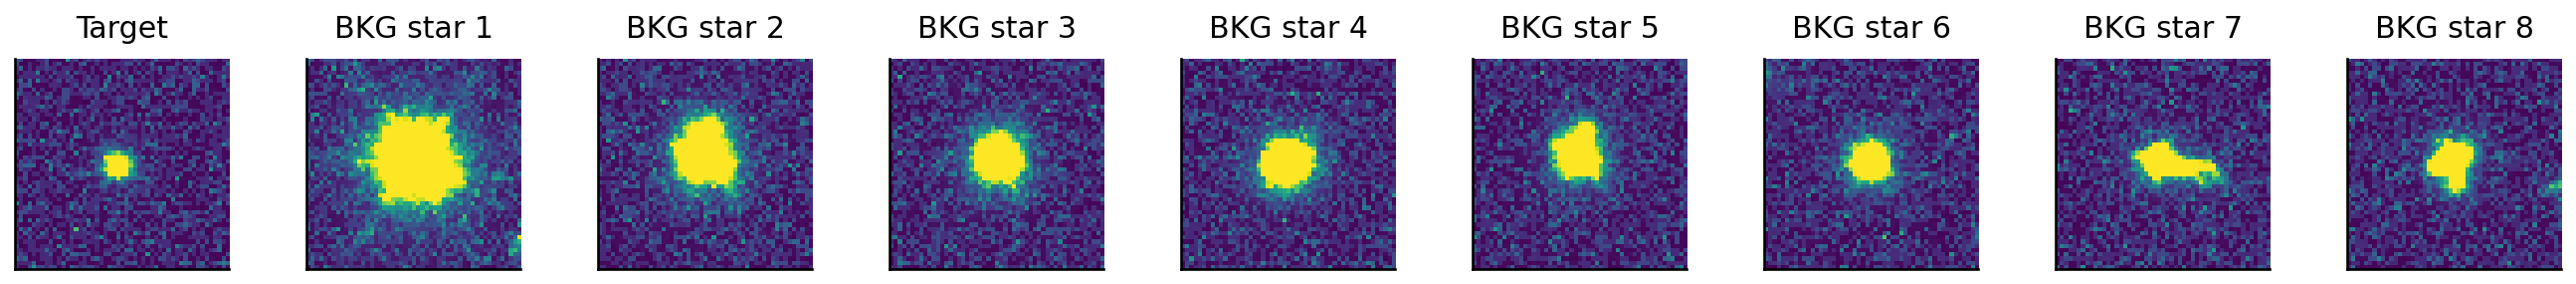

In [21]:
p.VISDA.plot_TPFs();

To simulate the time series, you can use `get_target_timeseries` and pass in a function which describes your expected normalized time-series variability as a function of time:

In [22]:
time, flux = p.VISDA.get_target_timeseries(ts_func=targ.box_transit, subarray=0)

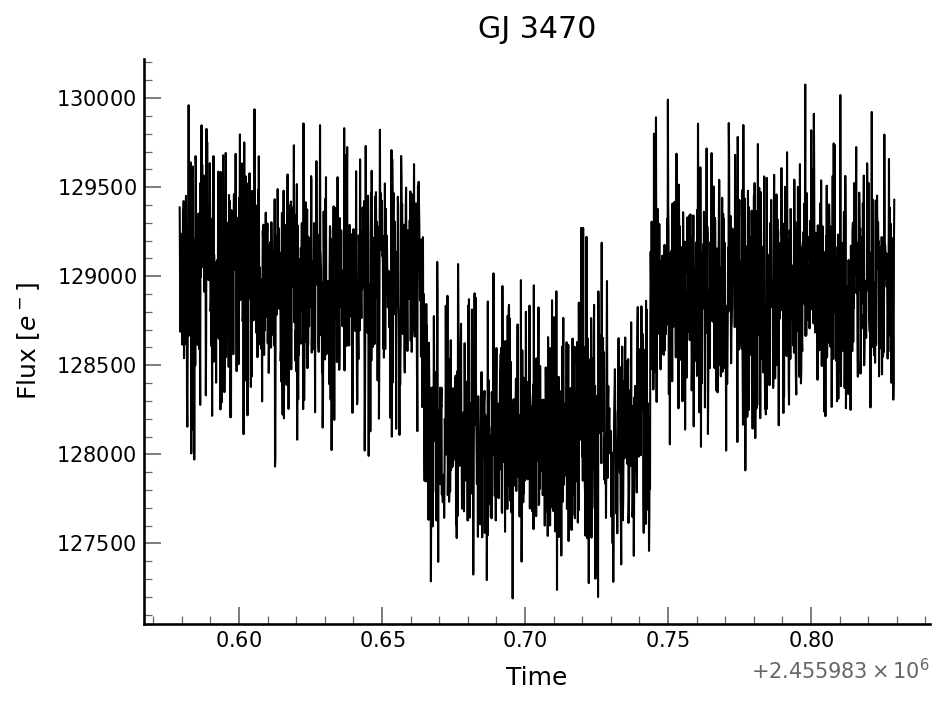

In [35]:
with plt.style.context(ps.PANDORASTYLE):
    fig, ax = plt.subplots()
    ax.plot(time, flux, c='k', lw=1)
    ax.set(xlabel='Time', ylabel='Flux [$e^-$]', title=targ.name)

I passed in a simple box transit from the target above, when I add in a true transit model this will improve. 

### What's happening here?

This is injecting the target flux at the pixel level in the PSF from LLNL, alongside background stars from the Gaia catalog with reasonable Pandora flux. We have reasonable noise estimates from what we know about the detector. (Note: these estimates will *update* so make sure to *update* your `pandora-sat`!)

This does **not** currently have expected jitter in it, but I'm working on adding it. Adding jitter drastically slows down the simulation so I need to get a bit smarter on the interpolation, but I think I can speed it up.

# Making a NIRDA trace

Here we're using "trace" to mean the spectrum dispersed onto the detector. This has some thickness to it.

To make a NIRDA trace we're going to use this fast trace function. This is definitely going to change, and will be wrapped up in a nice function for you in future.

In [24]:
wav_edges, fasttrace = p.NIRDA.get_fasttrace(sub_res=9, npix=2)

Building fasttrace: 100%|█████████████████████████| 9/9 [02:32<00:00, 16.92s/it]


We need to know where the source falls on the detector, this function will include expected distortions

In [25]:
row, col = p.NIRDA.world_to_pixel(p.ra, p.dec)[:, 0]

We need to integrate the spectrum across the sensitivity, and calculate the integrated spectrum at each wavelength element

In [26]:
integral = p.NIRDA.get_integrated_spectrum(w, targ.spectrum(w), wav_edges, plot=True)

Then we can calculate the "trace" at that point

In [27]:
r, c, prf = fasttrace(row, col)
trace = (integral[:, None, None] * prf).sum(axis=0)

If we plot the integral compared with the trace, we see that the PSF blurs out the features in wavelength.

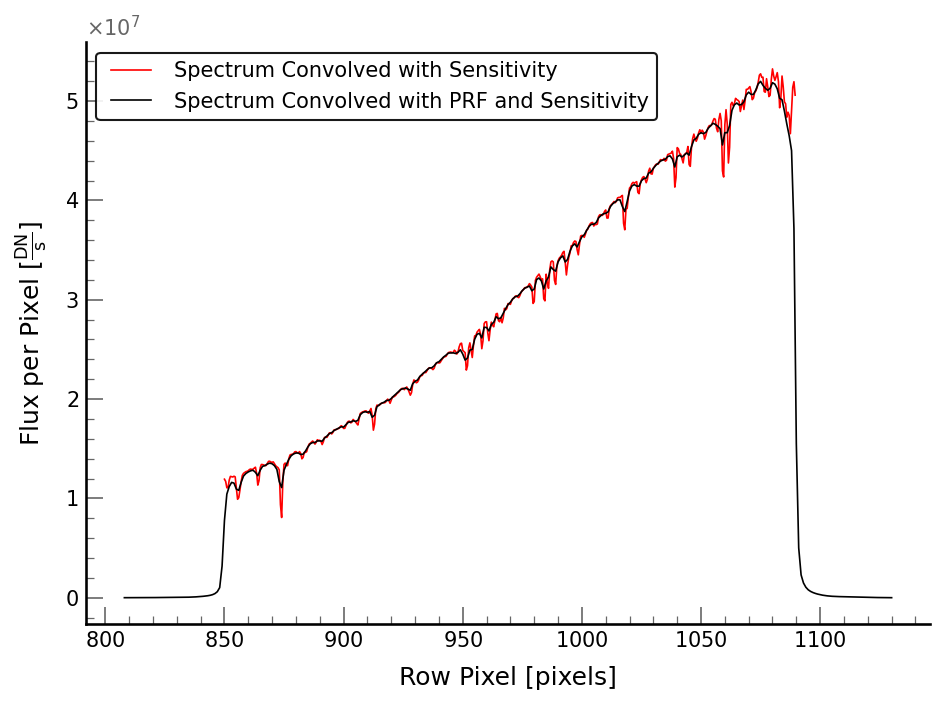

In [28]:
npix = 2
with plt.style.context(ps.PANDORASTYLE):
    fig, ax = plt.subplots()
    w1 = p.NIRDA.wavelength_to_pixel(wav_edges.mean(axis=1) * u.micron).value + row
    ax.plot(w1, integral * npix, label='Spectrum Convolved with Sensitivity', c='r')
    ax.plot(r, trace.sum(axis=1), c='k', label='Spectrum Convolved with PRF and Sensitivity')
    ax.set(xlabel=f"Row Pixel [pixels]", ylabel=f"Flux per Pixel [{integral.unit.to_string('latex')}]")
    ax.legend(frameon=True)

Here we can see the trace as an image

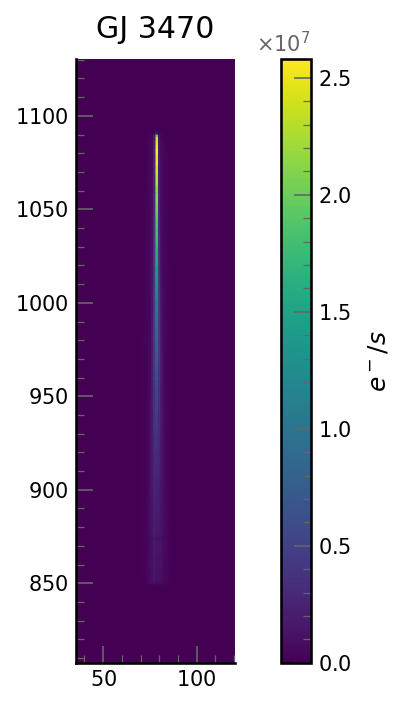

In [29]:
with plt.style.context(ps.PANDORASTYLE):
    fig, ax = plt.subplots()
    plt.pcolormesh(c, r, trace.value, cmap='viridis')
    plt.gca().set_aspect('equal')
    cbar = plt.colorbar()
    cbar.set_label('$e^-/s$')
    ax.set(title=f'{targ.name}')

However we need to include extra targets from the background.

In [30]:
from pandorasat.utils import get_phoenix_model

In [31]:
integrals = []
for idx, c in tqdm(p.NIRDA.Catalog.iterrows(), total=len(p.NIRDA.Catalog), desc='Calculating Star Integrals'):
    w, s = get_phoenix_model(teff=c.teff if np.isfinite(c.teff) else 5777, 
                             logg=c.logg if np.isfinite(c.logg) else 4.5,
                             jmag=c.jmag)
    integrals.append(p.NIRDA.get_integrated_spectrum(w, s, wav_edges, plot=True) * p.NIRDA.frame_time)

Calculating Star Integrals: 100%|███████████████| 20/20 [00:00<00:00, 20.85it/s]


In [32]:
corner = p.NIRDA.subarray_corner
size = p.NIRDA.subarray_size
R, C = p.NIRDA.subarray_row, p.NIRDA.subarray_column
s = np.zeros(p.NIRDA.subarray_size)
cat = p.NIRDA.Catalog
for i, r1, c1 in zip(integrals, np.asarray(cat.nir_row), np.asarray(cat.nir_column)):
    r, c, prf = fasttrace(r1, c1)
    subtrace = (i[:, None, None] * prf).sum(axis=0)
    ok1 = (((r - corner[0]) >= 0) & ((r - corner[0]) < size[0]))[:, None] & ((c - corner[1]) >= 0) & ((c - corner[1]) < size[1])
    ok2 = np.in1d(R[:, 0],  r)[:, None] & np.in1d(C[0],  c) 
    s[ok2] += subtrace.value[ok1]
s = p.NIRDA.apply_gain(s*u.DN)

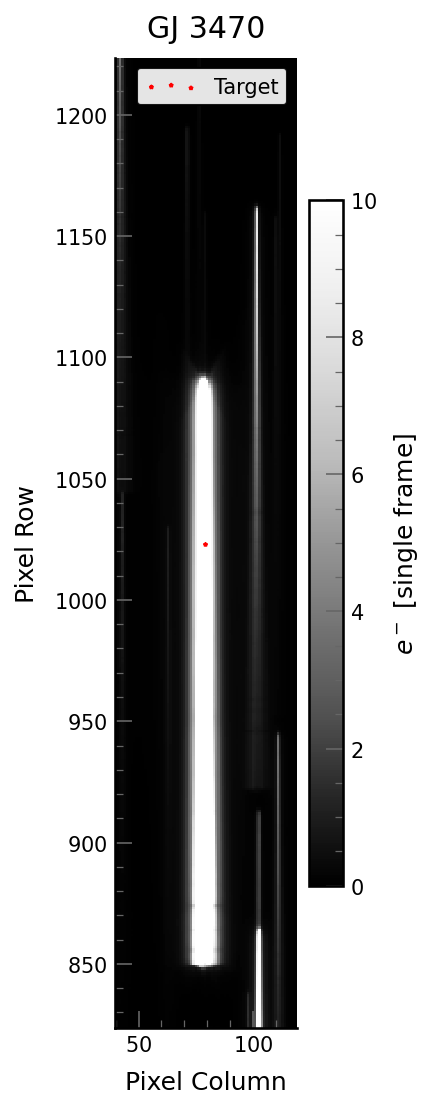

In [33]:
with plt.style.context(ps.PANDORASTYLE):
    fig, ax = plt.subplots(figsize=(3, 1.5 * np.divide(*p.NIRDA.subarray_size)))
    im = ax.pcolormesh(p.NIRDA.subarray_column, p.NIRDA.subarray_row, s, vmin=0, vmax=10, cmap='Greys_r')
    ax.scatter(*p.NIRDA.world_to_pixel(p.NIRDA.ra, p.NIRDA.dec).T[0][::-1], c='r', marker='*', label='Target')
    ax.legend(frameon=True)
    ax.set(xlabel='Pixel Column', ylabel='Pixel Row',title=targ.name)
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('$e^-$ [single frame]')